# Analyzing Political Bias in ConceptNet Numberbatch and GloVe 840B Embeddings

By Elias Mann and Mark Brubaker

# Introduction

In this notebook, we will analyze the political bias of two word embeddings: ConceptNet Numberbatch and GloVe 840B. This is a relevent topic as the popular word embeddings are widely used in large language models (LLMs) and other NLP tasks. As of writing this notebook (February 2023) the use of LLMs has just reached the mainstream. With the OpenAI's release of ChatGPT and its viral reception, people are using LLMs more than ever. Bing has incorporated a version of ChatGPT into their search engine and a race to deploy LLMs at scale as begun, with competitors like Microsoft, Google, Facebook and Amazon all working on their own versions. <br><br>
While these LLMs have shown to be impressive tools for tasks from text sumarizations to song writing and even code generation, these models do come with their caveats. As  detailed in the paper [*On the Dangers of Stochastic Parrots: Can Language Models Be Too Big? 🦜*](https://dl.acm.org/doi/pdf/10.1145/3442188.3445922), large language models are prone to bias which can have significant repercussions in perpetuating these biases depending on their use cases. For example, many are using LLMs in place of search engines to ask factual questions. While there are many issues at play here, one is that political bias can influence the nature of the answer. In a text summarization use case, the model can alter the political leaning of the originial text, or insert one that was not there in the first place. While political beleifs are constantly changing, the embeddings of these models cannot be changed as easily. This means that the bias of these models will be perpetuated for years to come and will no longer represent political leaning as tides shift. Additionally, perpetuating bias at scale leads to more polarity among the populus.<br><br>
This investigation is relevant to other researchers and practitioners as it will help them to better understand the political bias of these models. This information can also help them understand which use cases are appropriate for these embeddings. Our findings may also lead researchers and practitioners to re-evaluate their existinig models that use these embeddings and consider mitigation techniques,or alternatives. <br>

## Research Question

Does political bias exist in ConceptNet Numberbatch and GloVe 840B embeddings? If so, to what extent does this bias exist? How do these embeddings compare to each other in terms of political bias?<br><br>
In investigating these questions, when we say "political bias" we are referring to the political leaning in the context of the United States. We are not referring to the political leaning of the embeddings themselves. For example, we are not saying that the embeddings are "left-leaning" or "right-leaning" but rather that the embeddings are biased towards a certain political leanings.


### Methods

In order to conduct this investigation, we will train two classifiers on news headlines from highly polarized news sources. The models will be identical, and trained on the same data, but one with ConceptNet Numberbatch embedding and the other with GloVe 840B embedding. We will then use these classifiers to assign political leanings to headlines from a new source that is neither left-leaning nor right-leaning. Next, we will hand-pick 100 headlines that we have decided are apolitcal. Finally, we will predict the political leanings of these headlines using both models and compare the results. If the embeddings contain bias, we would expect the models with the embeddings to label the nuetral headlines as right, or left leaning. <br><br>

In order to decide which news sources to use, we refer to the paper [*Auditing Partisan Audience Bias within Google Search*](https://dl.acm.org/doi/pdf/10.1145/3274417) and rely on their research in determine bias scores for different news sources. We observed which of the news sources with bias scores existed in our [news headlines dataset](https://www.kaggle.com/datasets/snapcrack/all-the-news). From these news sources we decided to use Vox as our left leaning source, Fox News as our right leaning source, and Business Insider as our neutral source. In the paper mentioned above, the authours assigned bias scores on a scale of -1 to 1, with -1 being the most left leaning, 1 being the most right leaning and 0 being neutral. The scores for the news sources we chose are as follows: 
- Vox: -0.5546
- Fox News: 0.6079
- Business Insider: -0.0373

We chose these sources for abundance of data, similar bias score magnitudes in their respective affiliations, and the fact that they are all promninent news sources.

### Hypothesis

We hypothesize that our embeddings do indeed contain political bias as it is generally very difficult to create unbiased data. We also hypothesize that the bias will be more pronounced GloVe 840B embeddings as they are trained on a larger corpus of data, which is based on a large portion of text that exists on the internet. Since ConceptNet is curated by humans with bias mitigation in mind, we believe that it will contain less political bias. <br><br>

## Comparing the Two Methods

In this project we will be comparing two identical models trained on identical data, one with ConcepNet Numberbatch as a word embedding and with GloVe 840b as a word embedding on the other. In order to compare the two models, we will predict the polarity of headlines from a new source that is neither left-leaning nor right-leaning. And we will also predict the polarity of "expert" (us) chosen headlines that we deemed to be completely neutral in political polarity.<br><br>
The polarity of the models are independant from one another. In our methods, predictions closer to 0.5 are considered neutral. The model that deviates most from 0.5 is considered to be the most biased. However we beleive that the meaningful analysis of this study will not come from comparing the two models to each other, but it will come from independantly comparing each model to the 0.5 baseline. Conclusions on whether one embedding is more biased than the other would be secondary to the conclusions on whether the embeddings are independantly biased.<br><br>
Some limitaions of our analysis is that it could be argued that our models are simply predicting if Business Insider headlines are more similar to those of Vox or Fox News. This is why we are hand-picking unbiaed headlines to compare to the models. Aditionally, we are training our models to classify headines as left leaning or right leaning. Since we do not train on neutral data, accuracy may be lower for headlines that should be classified as neutral. We did not include Business Insider headlines in our training data as we did not want to train our models to predict the style of Business Insider headlines.<br><br>

# Model Training

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, MaxPooling1D, Conv1D, Input, Dense, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os

# silence tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2023-02-22 14:01:03.847893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
 
if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

2023-02-22 14:01:06.529374: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-22 14:01:06.530709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-22 14:01:06.611614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-22 14:01:06.611649: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-22 14:01:06.615267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-22 14:01:06.615315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.4.1
Keras version: 2.4.0
Using Tesla V100-SXM2-32GB


2023-02-22 14:01:07.270485: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


Below is a function for loading embeddings from memory.

In [3]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

First we will loas, tokenize and pad our headline data.

In [4]:
NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TITLE_LEN = 32 # maximum number of words
NUM_CLASSES = 2


# load data
labeled_content = pd.read_csv('data/labeled_headlines.csv')
labeled_content = labeled_content[labeled_content['score'] != 0]

# load embeddings
X = labeled_content['title'].astype(str).values
y = labeled_content['score'].values

# tokenize
tokenizer = Tokenizer(
                    num_words=NUM_TOP_WORDS,
                    filters = '—!"“”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t…\'‘’'
                     )
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# get word index
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))

# pad sequences
X = pad_sequences(sequences, maxlen=MAX_TITLE_LEN)
y = np.where(y == -1, 0, 1)

print(f"Found {len(word_index):,} unique tokens. Distilled to {top_words:,} top words.")

Found 12,013 unique tokens. Distilled to 12,013 top words.


Below is a function that creates an embedding matrix with the words that exists both in our corpus and in the embeddings.

In [5]:
# now fill in the matrix, using the ordering from the
# keras word tokenizer from before
def generate_embed_matrix(embed):
    EMBED_SIZE = embed.shape[1]
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

    for word, i in word_index.items():

        try:
            embedding_vector = embed.loc[word]
            # words not found in embedding index will be ALL-ZEROS
            embedding_matrix[i] = embedding_vector
            found_words = found_words+1
        except:
            #print(word)
            pass

    print(f"Embedding Shape: {embedding_matrix.shape}")
    print(f"Total words found: {found_words:,}")
    print(f"Percentage: {round(100 * found_words / embedding_matrix.shape[0], 2)}")
    
    return embedding_matrix

Below is a function that creates a CNN model with the embedding matrix as an input. We use 1 convolutional layer, 2 dense layers and 1 output layer.

In [6]:
#function for generating the model with the embedding matrix
def generate_model(embed_matrix):
    EMBED_SIZE = embed_matrix.shape[1]
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBED_SIZE,
                                weights=[embed_matrix],# here is the embedding getting saved
                                input_length=MAX_TITLE_LEN,
                                trainable=False)

    # Define the input layer
    inputs = Input(shape=(MAX_TITLE_LEN,), dtype=tf.int32)
    embedding = embedding_layer(inputs)

    # Add a 1D Convolutional layer
    x = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_initializer='he_uniform')(embedding)

    # Add a Max Pooling layer
    x = MaxPooling1D(pool_size=2)(x)

    # Flatten the output of\ the Max Pooling layer
    x = Flatten()(x)
    x = Dropout(0.10)(x)
    x = Dense(units=64, activation='sigmoid')(x)
    x = Dense(units=32, activation='sigmoid')(x)

    # Add a Dense output layer with a single neuron and a sigmoid activation function
    outputs = Dense(units=1, activation='linear')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

The code blocks below are commented out and they contain functionality to load the embeddings, and generate the embed matrix, then save the embed matrix to a pickle file. Since we have already run this code, we will load the embed matrix from the pickle file.

In [7]:
# Initially loading in the numberbatch embeddings, time consuming and once loaded in, can be saved to disk
# %%time
# numberbatch_embeddings = load_embeddings("embeddings/numberbatch-en-17.04b.txt")
# numberbatch_embeddings.shape

In [8]:
#generating the embedding matrix, not necessary to run after saving to disk
# numberbatch_embed_matrix = generate_embed_matrix(numberbatch_embeddings)

In [9]:
numberbatch_pickle_file = "embeddings/numberbatch_matrix.pickle"

#save the embedding matrix to disk
# with open(numberbatch_pickle_file, 'wb') as f:
#     # pickle the embedding matrix
#     pickle.dump(numberbatch_embed_matrix, f)
#     # print a message to confirm the pickling
#     print(f"Embedding matrix pickled to {numberbatch_pickle_file}")

In [10]:
#reading in the embedding matrix from disk
with open(numberbatch_pickle_file, 'rb') as f:
    # load the pickled embedding matrix
    numberbatch_embed_matrix = pickle.load(f)
    # print a message to confirm the loading
    print(f"Embedding matrix loaded from {numberbatch_pickle_file}")

Embedding matrix loaded from embeddings/numberbatch_matrix.pickle


Below we generatre teh model with conceptnet numberbatch embeddings.

In [11]:
#generating the model with the numberbatch embedding matrix
numberbatch_model = generate_model(numberbatch_embed_matrix)
numberbatch_model.summary()

2023-02-22 14:01:07.638503: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-22 14:01:07.640115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-22 14:01:07.640169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-22 14:01:07.640197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-22 14:01:07.640209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-22 14:01:07.640220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 32, 300)           3604200   
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 128)           192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                114752

In [12]:
#splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=402)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6958, 32)
X_test shape: (1740, 32)
y_train shape: (6958,)
y_test shape: (1740,)


In [13]:
#fitting the model
numberbatch_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=35)

Epoch 1/35


2023-02-22 14:01:08.080427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-22 14:01:08.081058: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-02-22 14:01:08.430077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-22 14:01:08.736024: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-02-22 14:01:09.801343: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-02-22 14:01:09.840237: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


4/4 [==============================] - 4s 529ms/step - loss: 0.6605 - accuracy: 0.5043 - val_loss: 0.3419 - val_accuracy: 0.5000
Epoch 2/35
4/4 [==============================] - 0s 47ms/step - loss: 0.3171 - accuracy: 0.4626 - val_loss: 0.2914 - val_accuracy: 0.4845
Epoch 3/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2927 - accuracy: 0.4991 - val_loss: 0.2673 - val_accuracy: 0.5011
Epoch 4/35
4/4 [==============================] - 0s 44ms/step - loss: 0.2564 - accuracy: 0.5068 - val_loss: 0.2201 - val_accuracy: 0.6345
Epoch 5/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2174 - accuracy: 0.7153 - val_loss: 0.2097 - val_accuracy: 0.8080
Epoch 6/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2079 - accuracy: 0.7902 - val_loss: 0.2020 - val_accuracy: 0.7787
Epoch 7/35
4/4 [==============================] - 0s 47ms/step - loss: 0.1989 - accuracy: 0.7883 - val_loss: 0.1855 - val_accuracy: 0.8443
Epoch 8/35
4/4 [=====================

In [14]:
#function for plotting the model history
def plot_history(history, name="Results"):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))
 
    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')
 
    plt.subplot(1,2,2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')
 
    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)
 
    plt.show()

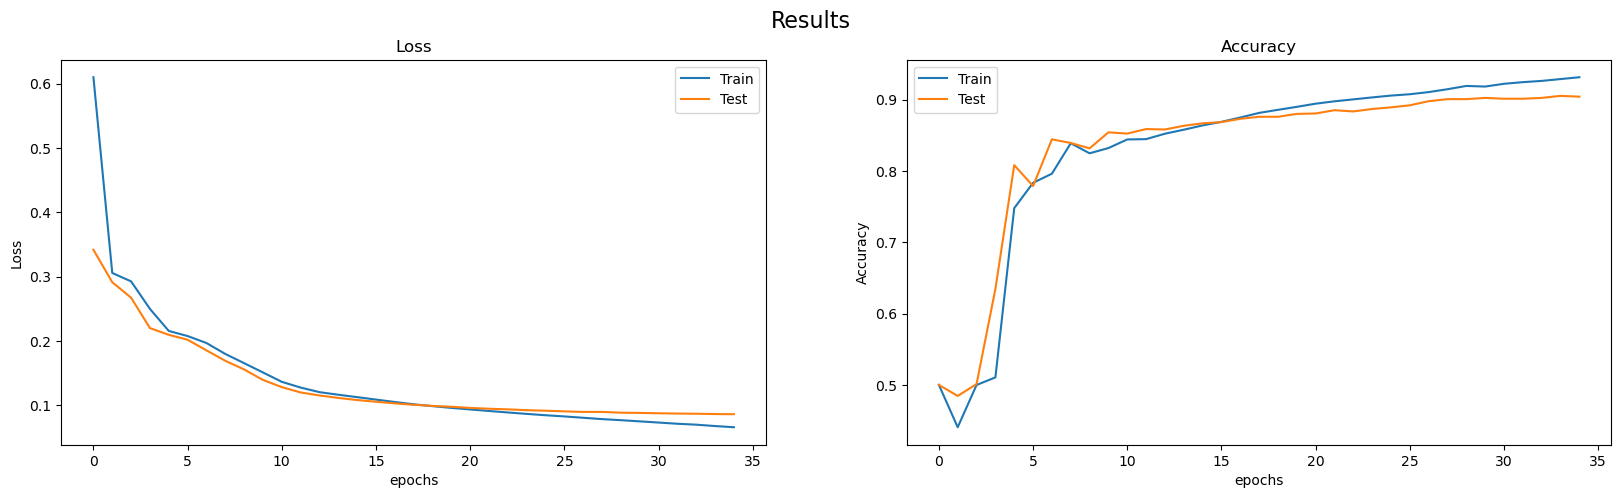

In [15]:
plot_history(numberbatch_model.history.history)

We believe that the model has converged.

Below is ducpliate code for loading the GloVe 840B embeddings, generating the embed matrix, saving to and reading from a pickle file.

In [16]:
# %%time
# glove_embeddings = load_embeddings("embeddings/glove.840B.300d.txt")
# glove_embeddings.shape

In [17]:
#glove_embed_matrix = generate_embed_matrix(glove_embeddings)
# define the file name for the pickle file

glove_pickle_file = "embeddings/glove_matrix.pickle"
# # open the file for writing in binary mode
# with open(glove_pickle_file, 'wb') as f:
#     # pickle the embedding matrix
#     pickle.dump(embedding_matrix, f)
#     # print a message to confirm the pickling
#     print(f"Embedding matrix pickled to {glove_pickle_file}")

In [18]:
# open the pickle file for reading in binary mode
with open(glove_pickle_file, 'rb') as f:
    # load the pickled embedding matrix
    glove_embed_matrix = pickle.load(f)
    # print a message to confirm the loading
    print(f"Embedding matrix loaded from {glove_pickle_file}")

Embedding matrix loaded from embeddings/glove_matrix.pickle


Epoch 1/35
4/4 [==============================] - 1s 75ms/step - loss: 0.2860 - accuracy: 0.5041 - val_loss: 0.2365 - val_accuracy: 0.5316
Epoch 2/35
4/4 [==============================] - 0s 43ms/step - loss: 0.2187 - accuracy: 0.6050 - val_loss: 0.1922 - val_accuracy: 0.7598
Epoch 3/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1836 - accuracy: 0.7794 - val_loss: 0.1651 - val_accuracy: 0.7851
Epoch 4/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1551 - accuracy: 0.7937 - val_loss: 0.1501 - val_accuracy: 0.7856
Epoch 5/35
4/4 [==============================] - 0s 42ms/step - loss: 0.1375 - accuracy: 0.8109 - val_loss: 0.1327 - val_accuracy: 0.8305
Epoch 6/35
4/4 [==============================] - 0s 42ms/step - loss: 0.1261 - accuracy: 0.8503 - val_loss: 0.1196 - val_accuracy: 0.8500
Epoch 7/35
4/4 [==============================] - 0s 43ms/step - loss: 0.1164 - accuracy: 0.8600 - val_loss: 0.1117 - val_accuracy: 0.8632
Epoch 8/35
4/4 [===========

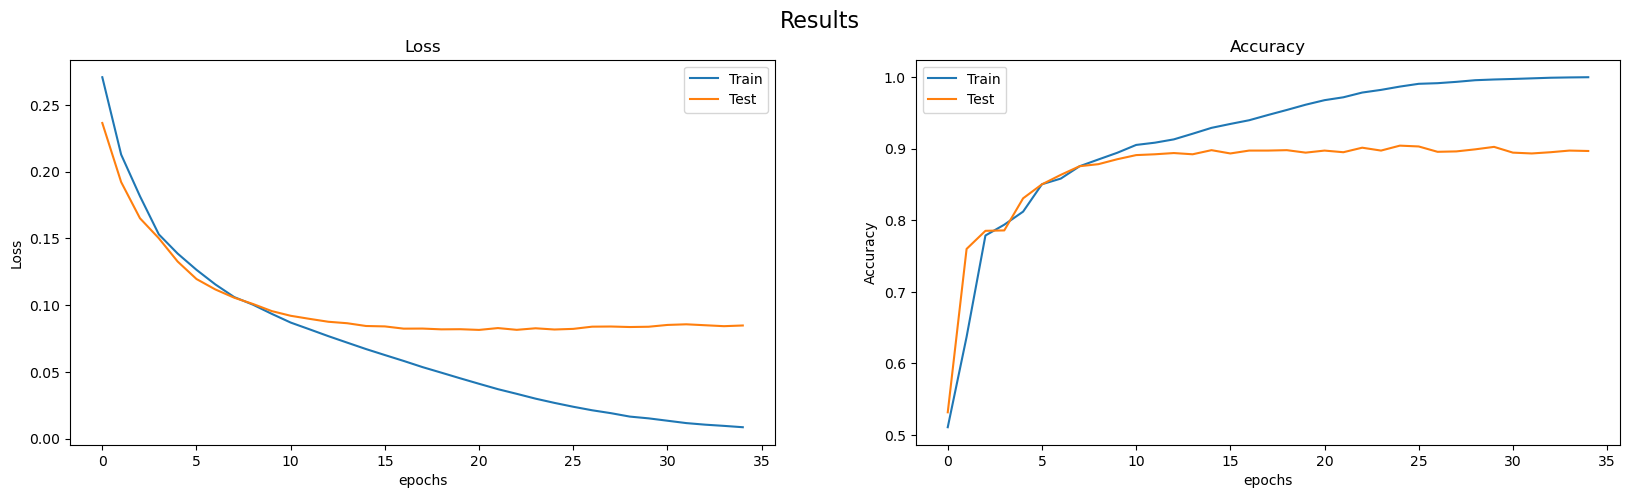

In [19]:
glove_model = generate_model(glove_embed_matrix)
glove_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2048, epochs=35)
plot_history(glove_model.history.history)

In [20]:
labeled_test = pd.read_csv('data/business_insider_headlines.csv')

test = labeled_test['title'].astype(str).values

seq = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(seq, maxlen=MAX_TITLE_LEN)

Below is a function for plotting the distributions of the predictions of the two models.

In [21]:
def plot_distros(test_distribution, neutral_dist, title, color):
    plt.figure(figsize=(20, 5))
    plt.rcParams.update({'font.size': 14})

    plt.subplot(1,2,1)
    plt.hist(test_distribution,30,color=color)
    plt.xlabel('Polarity of Titles (0 = left, 1 = right)')
    plt.ylabel('Number of Titles')
    plt.title('X_test')
    plt.xlim([-.5, 1.5])

    plt.subplot(1,2,2)
    plt.hist(neutral_dist,30,color=color)
    plt.xlabel('Polarity of Titles (0 = left, 1 = right)')
    plt.ylabel('Number of Titles')
    plt.title('Business Insider')
    plt.xlim([-.5, 1.5])

    # set the title for the whole figure
    plt.suptitle(title, fontsize=20)

    plt.show()

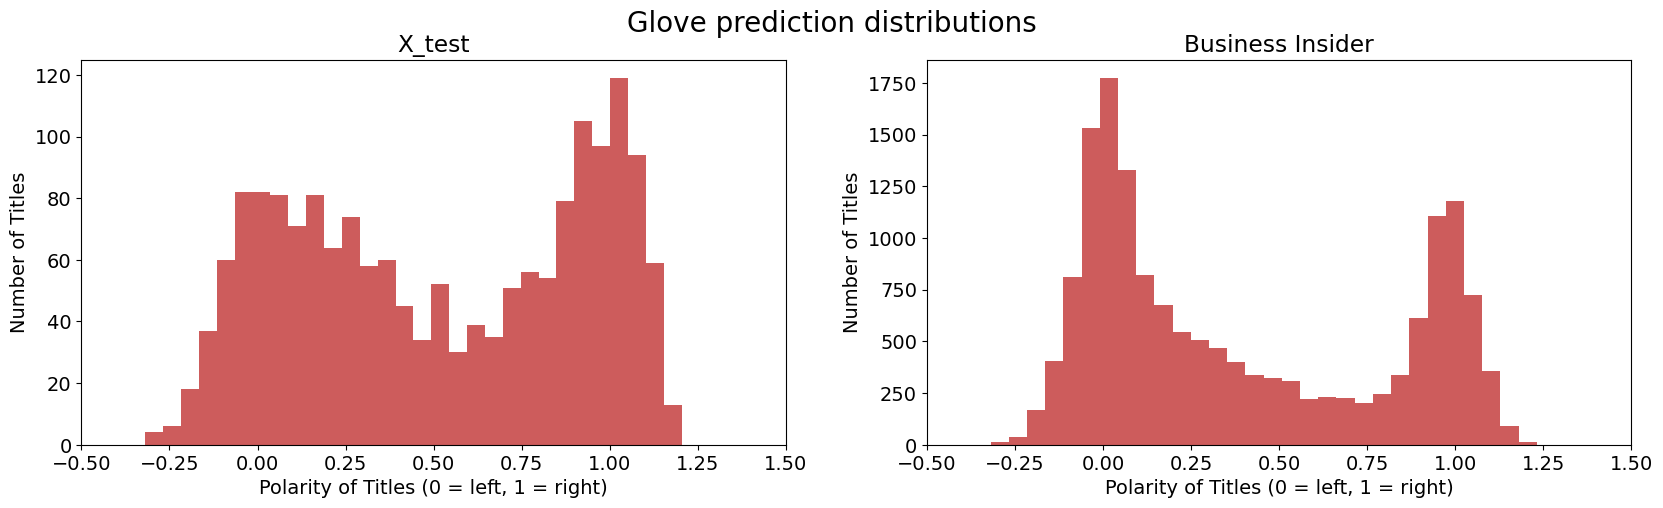

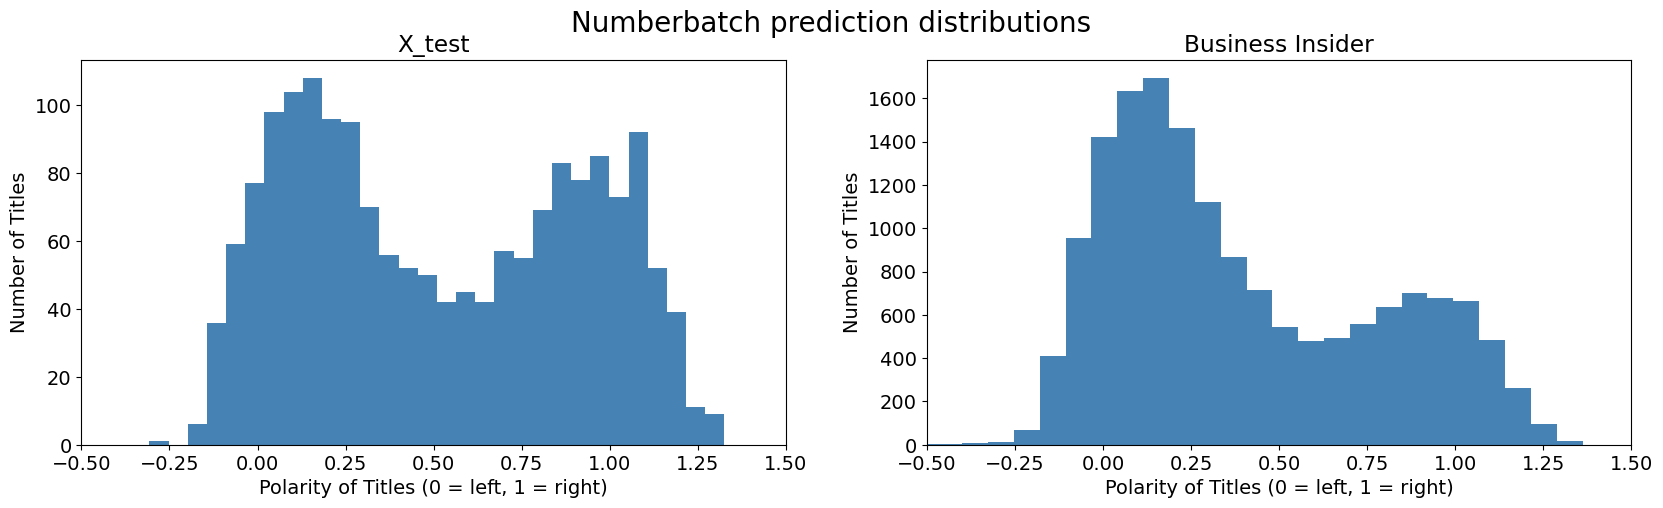

In [22]:
glove_test_distribution = glove_model.predict(X_test)
glove_neutral_dist = glove_model.predict(test_padded)

numberbatch_test_distribution = numberbatch_model.predict(X_test)
numberbatch_neutral_dist = numberbatch_model.predict(test_padded)

plot_distros(glove_test_distribution, glove_neutral_dist,'Glove prediction distributions', 'indianred')
plot_distros(numberbatch_test_distribution, numberbatch_neutral_dist,'Numberbatch prediction distributions', 'steelblue')

In [23]:
# print the mean of the distributions for the test set
print("Test set:")
print("Numberbatch mean: " + str(numberbatch_test_distribution.mean()))
print("Glove mean: " + str(glove_test_distribution.mean()))
print()

# print the mean of the distributions for the neutral samples
print("Neutral samples:")
print("Numberbatch mean: " + str(numberbatch_neutral_dist.mean()))
print("Glove mean: " + str(glove_neutral_dist.mean()))

Test set:
Numberbatch mean: 0.518337
Glove mean: 0.5158382

Neutral samples:
Numberbatch mean: 0.39367974
Glove mean: 0.3904138


When used on the test set both models hover close to the neutral value of .51, although the numberbatch model leans slightly closer to Fox News. An ideal model without any embedding bias and perfect accuracy would sit at exactly .5 

In order to detect bias in the embeddings we tested the models on titles that came from a news source that is not known to have a strong lean left or right. In the paper we used to select Vox and Fox, Buisness Insider was shown to be a mostly neutral media outlet and lie exactly between the other two outlets.

When tested on the supposedly unbiased titles from Buisness Insider the models center around about .39. This says more about the leaning of Buisness Insider titles than the bias in the underlying embeddings. Notably though, the numberbatch model still tends slightly further right.

Across several runs, the means shift slightly but the two models tend to keep the same distance and realtion to one another

In [24]:
labeled_expert = pd.read_csv('data/expert_neutral_headlines.csv')

print('Number of expertly selected headlines: ' + str(labeled_expert.shape[0]))

titles = labeled_expert['title'].astype(str).values

seq = tokenizer.texts_to_sequences(titles)
expert_padded = pad_sequences(seq, maxlen=MAX_TITLE_LEN)

Number of expertly selected headlines: 100


In order to be sure of the bias in the embeddings, we selected 100 headlines covering a variety of topics that had no discernible bias to them. Although some of the title subjects are politicly charged issuses, the headlines themselves do not have a clear bias to them one way or the other. By examining the models on this set of titles we can independntly confirm that any biases attached to these true neutral titles comes from the embeddings.

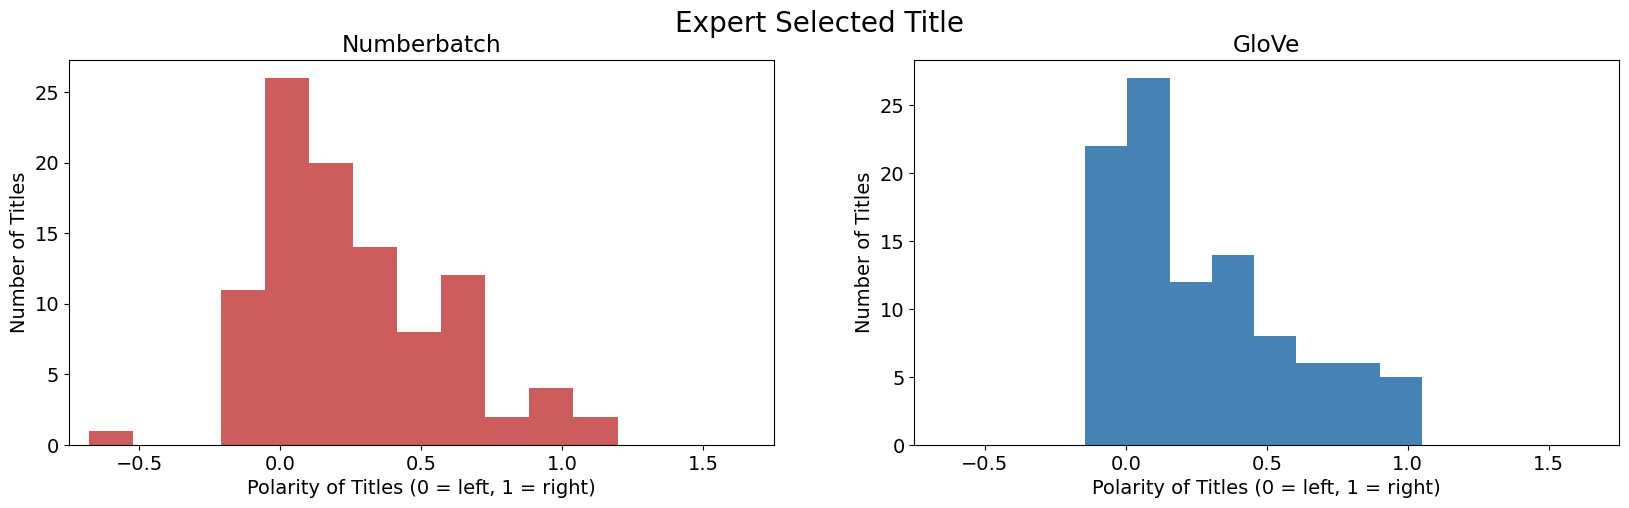

In [25]:
numberbatch_expert_neutral = numberbatch_model.predict(expert_padded)
glove_expert_neutral = glove_model.predict(expert_padded)

plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 14})

plt.subplot(1,2,1)
plt.hist(numberbatch_expert_neutral,bins=12,color='indianred')
plt.xlabel('Polarity of Titles (0 = left, 1 = right)')
plt.ylabel('Number of Titles')
plt.title('Numberbatch')
plt.xlim([-.75, 1.75])

plt.subplot(1,2,2)
plt.hist(glove_expert_neutral,bins=8,color='steelblue')
plt.xlabel('Polarity of Titles (0 = left, 1 = right)')
plt.ylabel('Number of Titles')
plt.title('GloVe')
plt.xlim([-.75, 1.75])

# set the title for the whole figure
plt.suptitle('Expert Selected Title', fontsize=20)

plt.show()

In [26]:
print("Numberbatch mean: " + str(numberbatch_expert_neutral.mean()))
print("Glove mean: " + str(glove_expert_neutral.mean()))

Numberbatch mean: 0.26488805
Glove mean: 0.27212393


When we try to explicitly select titles without bias the predicted leaning from both embeddings is revealed to be further left. Oddly this skew is even more pronounced than the whole selection of neutral titles. This may still represent more of the bias in Buisness Insider but provides more confidence that the natural tend of the embeddings is left.

In [27]:
def predict_text(text):
    print(text)
    tts = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(tts, maxlen=MAX_TITLE_LEN)
    
    number = numberbatch_model.predict(padded)
    glove = glove_model.predict(padded)
        
    print(f'The predicted Numberbatch polarity is: {round(float(number[0][0]), 4)}')
    print(f'The predicted GloVe polarity is:       {round(float(glove[0][0]), 4)}')
    print()

In [28]:
predict_text("A single payer healthcare is neccesary to help the poor")
predict_text("US special ops carry out raid deep inside ISIS territory and murder evil terroists")

A single payer healthcare is neccesary to help the poor
The predicted Numberbatch polarity is: 0.2058
The predicted GloVe polarity is:       0.1966

US special ops carry out raid deep inside ISIS territory and murder evil terroists
The predicted Numberbatch polarity is: 1.1914
The predicted GloVe polarity is:       0.9547



Here the models are shown to correctly predict clearly biased headlines, but this is not always the case. We asked ChatGPT to generate polarizing headlines and the used our models to predict the polarity.

In [29]:
far_left_headlines = [
    "Progressives demand sweeping police reform, including defunding and demilitarization",
    "Democratic lawmakers push for universal healthcare as a basic human right",
    "Green New Deal advocates call for massive government investment in renewable energy",
    "Abolish ICE activists rally against immigration policies that they say are inhumane",
    "Anti-racism protesters demand an end to systemic racism and police brutality",
    "LGBTQ advocates push for comprehensive protections against discrimination",
    "Socialists call for a complete overhaul of the capitalist system",
    "Advocates for reproductive rights fight for abortion access and comprehensive sex education",
    "Anti-war protesters demand an end to U.S. military intervention overseas",
    "Intersectional feminists call for a more inclusive and equitable society"
]

far_right_headlines = [
    "Conservatives push back against 'cancel culture' and political correctness run amok",
    "Republican lawmakers vow to protect Second Amendment rights amid gun control push",
    "MAGA supporters reject the results of the 2020 election, allege widespread voter fraud",
    "Pro-life activists call for an end to abortion and defunding of Planned Parenthood",
    "Nationalist groups decry open borders and advocate for strict immigration controls",
    "Pro-gun activists defend the right to bear arms as a fundamental American freedom",
    "Trump supporters call for a return to traditional American values and 'Make America Great Again'",
    "Far-right extremists organize against perceived threats to white identity and Western culture",
    "Anti-tax conservatives rally against what they see as overreaching government regulation",
    "Religious conservatives push for a return to traditional gender roles and family values"
]

polarizing_headlines = far_left_headlines + far_right_headlines

for headline in polarizing_headlines:
    predict_text(headline)

Progressives demand sweeping police reform, including defunding and demilitarization
The predicted Numberbatch polarity is: 0.5452
The predicted GloVe polarity is:       0.4287

Democratic lawmakers push for universal healthcare as a basic human right
The predicted Numberbatch polarity is: 0.6326
The predicted GloVe polarity is:       0.31

Green New Deal advocates call for massive government investment in renewable energy
The predicted Numberbatch polarity is: 0.7031
The predicted GloVe polarity is:       0.4244

Abolish ICE activists rally against immigration policies that they say are inhumane
The predicted Numberbatch polarity is: 0.4627
The predicted GloVe polarity is:       -0.1492

Anti-racism protesters demand an end to systemic racism and police brutality
The predicted Numberbatch polarity is: 0.2695
The predicted GloVe polarity is:       0.38

LGBTQ advocates push for comprehensive protections against discrimination
The predicted Numberbatch polarity is: 0.7076
The predicted 

The model seems correctly deviceive about many of these headlines also it is not uncommon that it overshoots in the wrong direction. While providing an interseting insight into the models it fails to reavel any clear understanding in the embedding biases. The nuance of the clear lean in each of these titles is often lost on both models even when it correctly identifies the ploarizing nature of them.

In [33]:
predict_text("Love peace and truth")
predict_text("The sky is blue")
predict_text("Today is a good day to take a walk")
predict_text("We now take a minute to mourn the loss of our loved ones")
predict_text("Rectangle")
predict_text("Panera Charged Lemonade")
predict_text("I attend SMU")
predict_text("The end of the world is near. Run for your lives!")

Love peace and truth
The predicted Numberbatch polarity is: 0.3137
The predicted GloVe polarity is:       0.2896

The sky is blue
The predicted Numberbatch polarity is: 0.1999
The predicted GloVe polarity is:       0.2259

Today is a good day to take a walk
The predicted Numberbatch polarity is: 0.1305
The predicted GloVe polarity is:       0.318

We now take a minute to mourn the loss of our loved ones
The predicted Numberbatch polarity is: 0.0317
The predicted GloVe polarity is:       0.2251

Rectangle
The predicted Numberbatch polarity is: 0.2266
The predicted GloVe polarity is:       0.2313

Panera Charged Lemonade
The predicted Numberbatch polarity is: 0.3895
The predicted GloVe polarity is:       0.5779

I attend SMU
The predicted Numberbatch polarity is: 0.3637
The predicted GloVe polarity is:       0.539

The end of the world is near. Run for your lives!
The predicted Numberbatch polarity is: 0.1235
The predicted GloVe polarity is:       0.2758



Here the models' predictions are shown on apolitical inputs. An ideal model would identify that and predict .5 for these. While exploring the output on more mundane prompts may be less applicable as they do not match the format of any trained data, they do reveal some more about the underlying biases. Almost all of these prompts get mild to strong left predictions by both models. Notably, while there are some left and center predictions there is a distanct lack of any right leaning predictions as confident as thoes to the left. Additionaly Numberbatch is consistantly predicts more left than GloVe, following its tendencies to predict more values futher from .5.

# Conclusion

Based on the findings of our analysis, we have arrived at the conclusion that both of the embeddings under investigation exhibit indications of bias. In particular, our experimentation has revealed that when applied to neutral news headlines, both embeddings tended to assign political leanings to the headlines. This outcome serves to confirm our initial hypothesis that the embeddings may be influenced by underlying biases. Notably, we acknowledge the inherent challenge of disentangling the impact of embedding bias from the biases present in the data. Despite this difficulty, our models consistently exhibited a tendency to predict text as leaning to the left, even when the text itself is not explicitly political in nature.

Regarding the comparison of the two embeddings, our results suggest that neither embedding is inherently more biased in the same direction than the other. The direction and degree of bias present in the embeddings appear to vary depending on the specific domain of the text. However, when considering the overall performance across multiple domains, our analyses indicate that the Numberbatch embedding exhibited a higher degree of variation from center bias as compared to GloVe. This finding, which runs contrary to our original hypothesis that GloVe would prove to be more biased, underscores the complexity and nuances of bias in language models.

In summary, our investigation has revealed that both embeddings display evidence of bias, with the Numberbatch embedding exhibiting a stronger tendency towards extreme predictions. Further research in this area is necessary to develop strategies to mitigate the impact of embedding bias and to promote greater fairness and accuracy in natural language processing.

# Works Cited
[*On the Dangers of Stochastic Parrots: Can Language Models Be Too Big? 🦜*](https://doi.org/10.1145/3442188.3445922).<br>
&nbsp;&nbsp;&nbsp;&nbsp;Bender, Emily M. and Gebru, Timnit and McMillan-Major, Angelina and Shmitchell, Shmargaret. Proceedings of the 2021 ACM Conference on Fairness, Accountability, and Transparency, 2021.<br><br>

[*Auditing Partisan Audience Bias within Google Search*](https://doi.org/10.1145/3274417).<br>
&nbsp;&nbsp;&nbsp;&nbsp;Robertson, Ronald E. and Jiang, Shan and Joseph, Kenneth and Friedland, Lisa and Lazer, David and Wilson, Christo. Proc. ACM Hum.-Comput. Interact., 2018.<br><br>

Kaggle Dataset: [*All the news*](https://www.kaggle.com/datasets/snapcrack/all-the-news).<br>




## Conferences/Journals that may be interested in our work

**FAccT: Fairness, Accountability, and Transparency at ACM** may be interested in this work as mitigating bias is relevant to their work. <br>

**Journal of Digital Humanities** may also be interested in our work as it related to understanding political bias in text which is relevant to their work in digital history. <br>